In [2]:
import nibabel as nib
import numpy as np
import hippomaps as hm
import matplotlib.pyplot as plt

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [29]:
# locate input data
source_dir = "ABA_v3/"
hippunfold_dir = "ABA_v3_hippunfold3/hippunfold/"

subs = ['01']
ses = ''
hemis = ['L']
labels = ['hipp']
den='0p5mm'

# here we will generate multiple depth-wise surfaces
depths = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(depths>=0,  depths <=1))[0]

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den)

# Map ABA subfield labels to hippocampus

In [23]:
cmd = f"wb_command -volume-to-surface-mapping {source_dir}/sub-01/anat/sub-01_annot.nii.gz "\
    f"{hippunfold_dir}/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii "\
    f"{hippunfold_dir}/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-ABA_subfields.label.gii -enclosing"
!{cmd}

ABAsubfs = nib.load(f"{hippunfold_dir}/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-ABA_subfields.label.gii").darrays[0].data

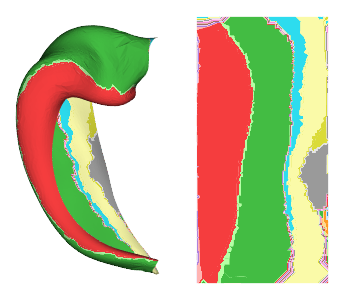

In [26]:
ABAsubfs_remap = np.zeros_like(ABAsubfs)
for i,l in enumerate(np.unique(ABAsubfs)):
    ABAsubfs_remap[ABAsubfs==l] = i
hm.plotting.surfplot_canonical_foldunfold(ABAsubfs_remap, hemis=['L'], labels=['hipp'], cmap='tab20', embed_nb=True)

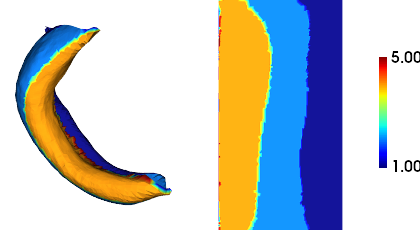

In [9]:
hm.plotting.surfplot_sub_foldunfold("ABA_v3_hippunfold3/hippunfold/", sub='01', ses='', features=['subfields-remap'], color_bar=('right'), hemis=['L'], labels=['hipp'], rotate=120, cmap='jet', unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

# Look at surface morphometry

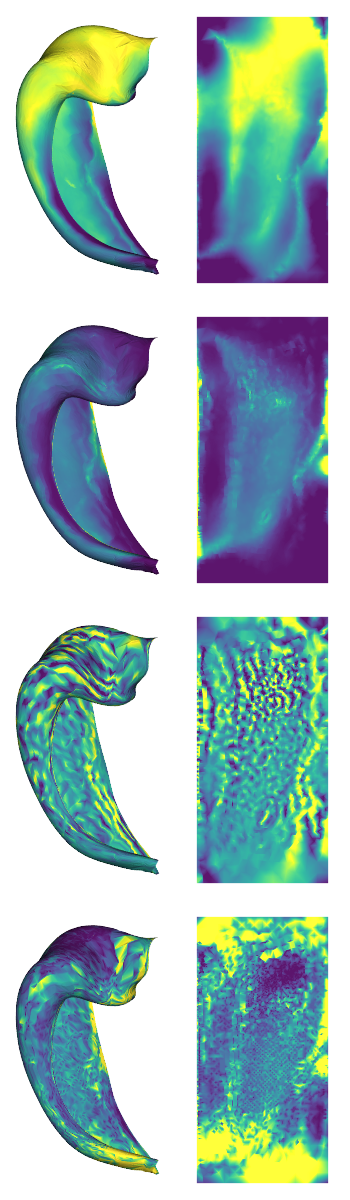

In [106]:
features = ['thickness', 'gyrification', 'curvature', 'surfarea']

hipp_dat_morph = np.zeros([nV,len(features)])*np.nan
for f,feat in enumerate(features):
    gii = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[0]}_space-T1w_den-0p5mm_label-hipp_{feat}.shape.gii')
    hipp_dat_morph[:,f] = gii.darrays[0].data
    
hm.plotting.surfplot_canonical_foldunfold(hipp_dat_morph, hemis=['L'], labels=['hipp'], tighten_cwindow=True, embed_nb=True)

# Build MPC and check structural gradients

In [73]:
from hippomaps.build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [85]:
cmd = f"mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths"
!{cmd}

# Create surfaces at various depths
hipp_dat = np.zeros([nV,len(depths)])*np.nan
cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
!{cmd}
for l,layer in enumerate(depths):
    cmd1 = f'wb_command -surface-cortex-layer '\
        f'{hippunfold_dir}/sub-{subs[0]}/surf/sub-{subs[0]}_hemi-{hemis[0]}_space-T1w_den-{den}_label-{labels[0]}_inner.surf.gii '\
        f'{hippunfold_dir}/sub-{subs[0]}/surf/sub-{subs[0]}_hemi-{hemis[0]}_space-T1w_den-{den}_label-{labels[0]}_outer.surf.gii '\
        f'{layer} '\
        f'{hippunfold_dir}/sub-{subs[0]}/surf/depths/sub-{sub}_hemi-{hemis[0]}_layer-{layer}.surf.gii'
    !{cmd1}
    cmd2 = f'wb_command -volume-to-surface-mapping '\
        f'{source_dir}/sub-{subs[0]}/anat/sub-{subs[0]}_T1w.nii.gz '\
        f'{hippunfold_dir}/sub-{subs[0]}/surf/depths/sub-{subs[0]}_hemi-{hemis[0]}_layer-{layer}.surf.gii '\
        f'{hippunfold_dir}/sub-{subs[0]}/surf/depths/sub-{subs[0]}_hemi-{hemis[0]}_layer-{layer}_intensity-default.shape.gii '\
        f'-trilinear'
    !{cmd2}
    gii = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[0]}_layer-{layer}_intensity-default.shape.gii')
    hipp_dat[:,l] = gii.darrays[0].data

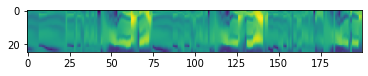

In [86]:
plt.imshow(hipp_dat[200:400,:].T)

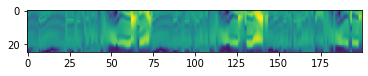

In [87]:
hipp_dat_aligned = hm.utils.profile_align(hipp_dat)
plt.imshow(hipp_dat_aligned[200:400,:].T)

In [93]:
MPC, I, problemNodes = build_mpc(hipp_dat_aligned.T)

/export03/data/hippomaps/hippomaps/build_mpc.py:145: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


(-0.5, 7261.5, 7261.5, -0.5)

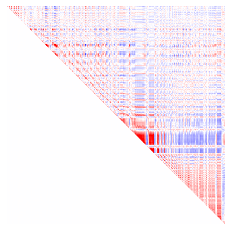

In [94]:
# plot the mMPC to get a sense of similarity between vertices.
plt.imshow(MPC, vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

In [99]:
mGM = GradientMaps(n_components=5)
mGM.fit(MPC, sparsity=0)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(n_components=5)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


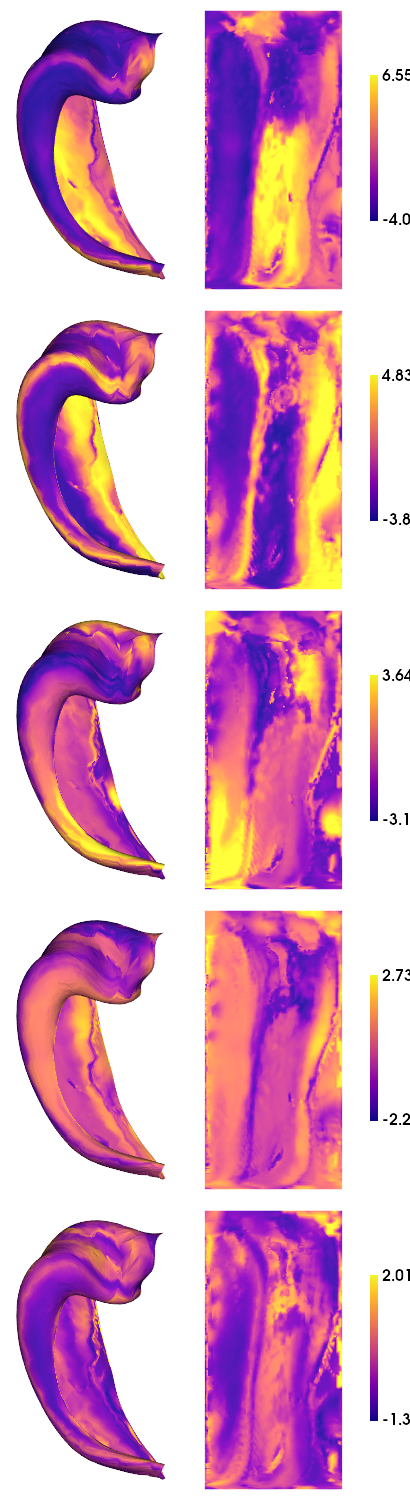

In [100]:
hm.plotting.surfplot_canonical_foldunfold(mGM.gradients_, labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

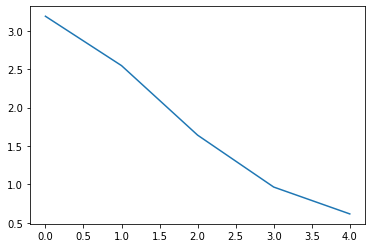

In [101]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(mGM.lambdas_)